Ingest the running_backs_2015_2025.csv file for data analysis and visualization

In [53]:
pip install seaborn pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\jerem\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
file_path = 'running_backs_2015_2025.csv'

df = pd.read_csv(file_path)
df.head()

,season,round,pick,team,pfr_player_id,pfr_player_name,college,position,position_rank,ht,...,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,receptions,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,fantasy_points
0,2015,1,10,STL,GurlTo01,Todd Gurley,Georgia,RB,RB1,6-1,...,1106.0,10.0,3.0,1.0,21.0,188.0,0.0,0.0,0.0,208.4
1,2015,1,15,SDG,GordMe00,Melvin Gordon,Wisconsin,RB,RB2,6-1,...,641.0,0.0,5.0,4.0,33.0,192.0,0.0,1.0,0.0,108.3
2,2015,2,36,JAX,YeldT.00,T.J. Yeldon,Alabama,RB,RB3,6-1,...,740.0,2.0,0.0,0.0,36.0,279.0,1.0,0.0,0.0,155.9
3,2015,2,54,DET,AbduAm00,Ameer Abdullah,Nebraska,RB,RB4,5-9,...,597.0,2.0,4.0,2.0,25.0,183.0,1.0,0.0,0.0,117.0
4,2015,3,73,ATL,ColeTe01,Tevin Coleman,Indiana,RB,RB5,5-11,...,392.0,1.0,3.0,3.0,2.0,14.0,0.0,0.0,0.0,42.6


Initially, we will be running some baseline exploratory analysis and basic correlation analysis using a heatmap to see what features are correlated highest with rookie fantasy point production. 

Below, we select only the **numeric** type columns which mainly includes draft selection data, college statistics, and combine statistics. 

In [56]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
target_columns = ['round', 'pick', 'wt', 'forty', 'bench', 'vertical',
       'broad_jump', 'cone', 'shuttle', 'college_carries', 'college_tds',
       'college_yards', 'college_long', 'college_ypc', 'fantasy_points']

numeric_df = numeric_df[target_columns]
numeric_df = numeric_df.dropna()

# In sports analytics especially, round and pick features are coded so that the higher value
# numbers (pick 200) are worse picks. This naturally leads to negative correlation with fantasy
# points. We invert this scale in order to achieve the correct correlation direction 
numeric_df['round_inv'] = numeric_df['round'].max() - numeric_df['round'] + 1
numeric_df['pick_inv'] = numeric_df['pick'].max() - numeric_df['pick'] + 1
numeric_df = numeric_df.drop(['pick', 'round'], axis=1)

# Similar to round/pick, forty yard dash time is "opposite" - higher forty time = slower (worse). 
# We create 'forty_rank' that inverts the forty column then converts to a rank (percentile) to
# handle the nonlinearity.
numeric_df['forty_rank'] = (-numeric_df['forty']).rank(pct=True)
numeric_df['cone_rank'] = (-numeric_df['cone']).rank(pct=True)
numeric_df['shuttle_rank'] = (-numeric_df['shuttle']).rank(pct=True)
numeric_df = numeric_df.drop(['forty', 'cone', 'shuttle'], axis=1)

print(numeric_df.head())

corr = numeric_df.corr()
target_corr = corr['fantasy_points'].sort_values(ascending=False)
target_corr.head()


      wt  bench  vertical  broad_jump  college_carries  college_tds  \
1  215.0   19.0      35.0       126.0            631.0         45.0   
2  226.0   22.0      36.0       117.0            576.0         37.0   
3  205.0   24.0      42.5       130.0            813.0         39.0   
6  224.0   25.0      41.5       127.0             88.0          4.0   
9  221.0   11.0      35.5       121.0            417.0         25.0   

   college_yards  college_long  college_ypc  fantasy_points  round_inv  \
1         4915.0          88.0          7.8           108.3          7   
2         3322.0          68.0          5.8           155.9          6   
3         4588.0          62.0          5.6           117.0          6   
6          410.0          37.0          4.7           211.8          5   
9         2306.0          79.0          5.5           145.7          4   

   pick_inv  forty_rank  cone_rank  shuttle_rank  
1       243    0.519231   0.490385      0.942308  
2       222    0.163462   

fantasy_points    1.000000
round_inv         0.683753
pick_inv          0.674903
cone_rank         0.295077
college_ypc       0.283732
Name: fantasy_points, dtype: float64

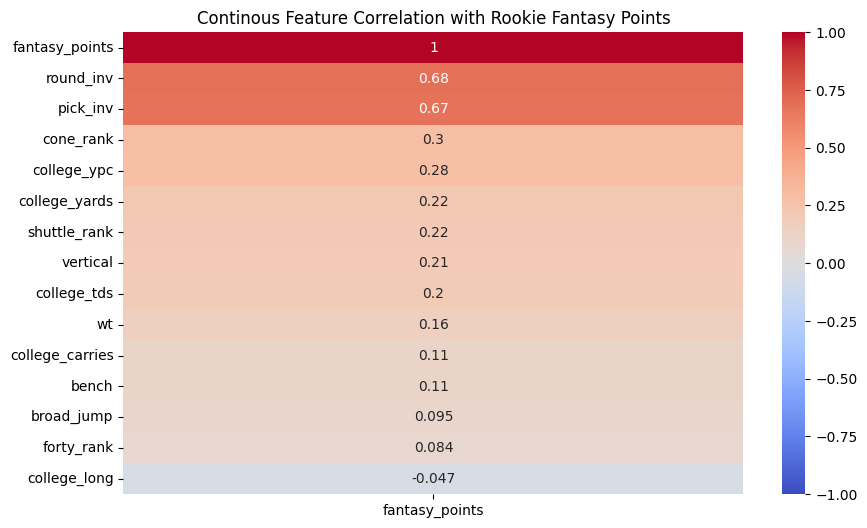

In [57]:
# heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr[['fantasy_points']].sort_values(by='fantasy_points', ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Continous Feature Correlation with Rookie Fantasy Points")
plt.show()

Initial observations of the heatmap show that draft pick and round order show the highest correlation to a running back's rookie fantasy points. This makes sense in the real world as typically the draft position is a summary signal of an NFL team's evaluation of a player's talent (on film and not just via statistics) and opportunity.

The next highest predictors are college yards, college ypc (yards per carry) and shuttle. For the former, these makes sense on paper as better college level production typically should indicate if a player will be also productive at the next level. 

Shuttle is the highest correlated combine statistic. This would make the most sense becuase the shuttle drill tests a RB's agility. Agility is most important in a position like RB where a lot of change of direction is important to be effective.

It is slightly surprising that most of the combine related features show lower correlation with fantasy points. Combine statistics typically measure a players athleticism which does not directly translate to football skills - they still need to be strong and fast of course. Statistics like weight (wt) and bench (measures overall chest muscle strength) still is somewhat relevant to a RB's production but not much. Other positions such as defense could value these features more, but for this scope, not as much.